# Background

## Description/Evaluation

Competition link: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

We are asking you to predict total sales for every product and store in the next month.

Evaluation: Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

Submission File: For each id in the test set, you must predict a total number of sales.

## Data

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

## Assessment

- For this assessment you will have 2 days to submit.
- You are required to use Python for this assessment
- You are required to include an EDA, with a link to the dataset/s you used.
- Get as far as you can in the 2 days and submit what you have. This is to see where your skills are strongest and weakest, so we can put together a well-balanced team.

Please fulfill the following instructions:

- Find a data set on Kaggle … any data set of interest to you (You are welcome to use more than one dataset if you find that one or more sets might add value to the insights of the original one you chose)
- Go through your data cleaning and data exploration as per normal
- Build an XGBoost regression model for your data set
- In a way that is comfortable to you, do a 3-step forecast (depending on the data you chose, this will be 3 days, 3 hours etc.)
 
Submission:

- Please load all your code, documentation, and data sets to your GitHub profile.
- Email your GitHub link to us.
- Include a readme file to your repository.

# EDA

files and notes: 

sales_train.csv - training data with features dates, data blocks, shop id, item id, item price, item count per day
items.csv - Matches item names to item id's, category id's. Probably want to use the category id in training.
item_categories.csv - Matches item category names to item category id's. Names in Russian. Probably unimportant.
shops.csv - Matches shop id to shop names. Some shop names seem similar (different branches of same company?) - could do some feature engineering with this if time.
test.csv - Predict total sales in the next month, per item, per shop. We'll ignore this for now, because we want to do forecasting. But can make a submission at the end.

# libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
# Auxiliary data
shops, items, item_categories = pd.read_csv("shops.csv"), pd.read_csv("items.csv"), pd.read_csv("item_categories.csv")

for dataframe in [shops, items, item_categories]:
    display(dataframe.head())


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [71]:
# training data, convert dates to datetime object
df = pd.read_csv("sales_train.csv", parse_dates=[0], dayfirst=True)


In [72]:
# there are some duplicate entries
df[df.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,2013-01-05,0,54,20130,149.0,1.0
76962,2013-01-05,0,54,20130,149.0,1.0
1435365,2014-02-23,13,50,3423,999.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496765,2014-03-23,14,21,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671872,2014-05-01,16,50,3423,999.0,1.0
1671873,2014-05-01,16,50,3423,999.0,1.0
1866322,2014-07-12,18,25,3423,999.0,1.0
1866340,2014-07-12,18,25,3423,999.0,1.0


In [73]:
# remove duplicates and use date as index
df.drop_duplicates(inplace=True)

df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-01,0,18,16182,1619.0,1.0
2013-01-01,0,54,12355,399.0,1.0
2013-01-01,0,54,16877,149.0,1.0
2013-01-01,0,27,15435,499.0,1.0
2013-01-01,0,54,19678,149.0,1.0
...,...,...,...,...,...
2015-10-31,33,50,8918,28.0,1.0
2015-10-31,33,6,8116,1699.0,1.0
2015-10-31,33,37,2423,499.0,3.0


In [10]:
# How much data
for dataframe in [df, shops, items, item_categories]:
    print(len(dataframe))


2935843
60
22170
84


In [11]:
df.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-01,0,18,16071,249.0,1.0
2013-01-01,0,54,10650,850.0,1.0
2013-01-01,0,54,10620,1000.0,1.0
2013-01-01,0,54,9736,298.0,1.0
2013-01-01,0,28,10242,249.0,1.0
2013-01-01,0,54,22151,399.0,1.0
2013-01-01,0,46,10394,149.0,1.0
2013-01-01,0,28,9813,399.0,1.0
2013-01-01,0,54,9577,149.0,1.0


In [12]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.300171e+01,1.019723e+04,8.908535e+02,1.242641e+00
std,9.422992e+00,1.622698e+01,6.324293e+03,1.729801e+03,2.618837e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [13]:
df.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [15]:
# don't seem to be any missing values
df.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [16]:
df.nunique()

date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [17]:
# let's add in item categories
df['item_category_id'] = df['item_id'].map(items.set_index('item_id')['item_category_id'])

df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-01-01,0,18,16071,249.0,1.0,65
2013-01-01,0,54,10650,850.0,1.0,67
2013-01-01,0,54,10620,1000.0,1.0,67
2013-01-01,0,54,9736,298.0,1.0,40
2013-01-01,0,28,10242,249.0,1.0,30


In [18]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.300171e+01,1.019723e+04,8.908535e+02,1.242641e+00,4.000141e+01
std,9.422992e+00,1.622698e+01,6.324293e+03,1.729801e+03,2.618837e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [19]:
# still no missing values
df.isnull().sum()

date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>,
        <AxesSubplot:title={'center':'item_category_id'}>]], dtype=object)

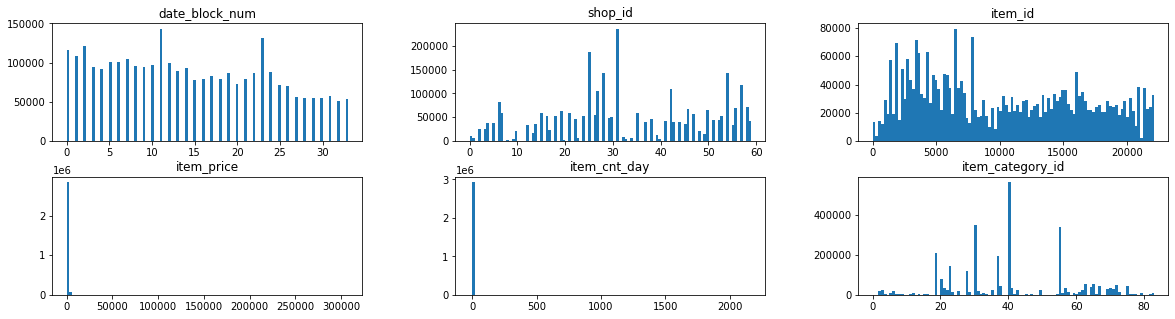

In [59]:
# check distributions
# some shops have significantly more entries than others, some item categories appear significantly more often than others
# low prices and low item_cnts appear much more often than higher values
# we see spikes in number of entries each year in december

df.hist(grid=False, bins=100, layout=(2, 3), figsize=(20, 5))

In [61]:
# there is a single entry with negative item_price - we should probably drop this
df[df['item_price'] < 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-05-15,4,32,2973,-1.0,1.0,19


In [70]:
# there are many negative item counts (returns?), across many dates, stores, item_id
# for now leave this as is
df[df['item_cnt_day'] < 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-01-01,0,27,12269,1499.0,-1.0,62
2013-01-01,0,18,6724,299.5,-1.0,21
2013-01-01,0,54,3429,2799.0,-1.0,23
2013-01-01,0,19,20383,1229.0,-1.0,72
2013-01-01,0,37,9601,849.0,-1.0,40
...,...,...,...,...,...,...
2015-12-09,32,37,3840,649.5,-1.0,23
2015-12-09,32,45,13460,1099.0,-1.0,21
2015-12-09,32,7,3076,1199.0,-1.0,19


<AxesSubplot:>

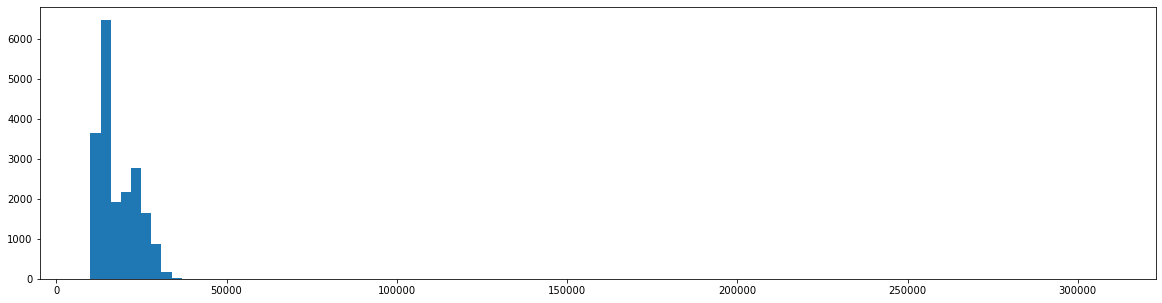

In [22]:
# by far most items are low price, look at more expensive item's distribution
df.loc[df['item_price'] > 1e4, 'item_price'].hist(grid=False, bins=100, figsize=(20, 5))

In [23]:
# only one item on one day was ever bought for more than 60,000 and it was over 300,000.
# this item was only bought once and is likely corporate software
# we can likely drop this outlier
df[df['item_price'] > 6e4]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-12-13,11,12,6066,307980.0,1.0,75


In [58]:
# this item was only bought one day ever
df[df['item_id'] == 6066]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-12-13,11,12,6066,307980.0,1.0,75


In [56]:
# what item is it?
# seems like remote support software for companies
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [57]:
# google translate says this is "computer programs for home and office"
item_categories[item_categories['item_category_id'] == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


19744


<AxesSubplot:>

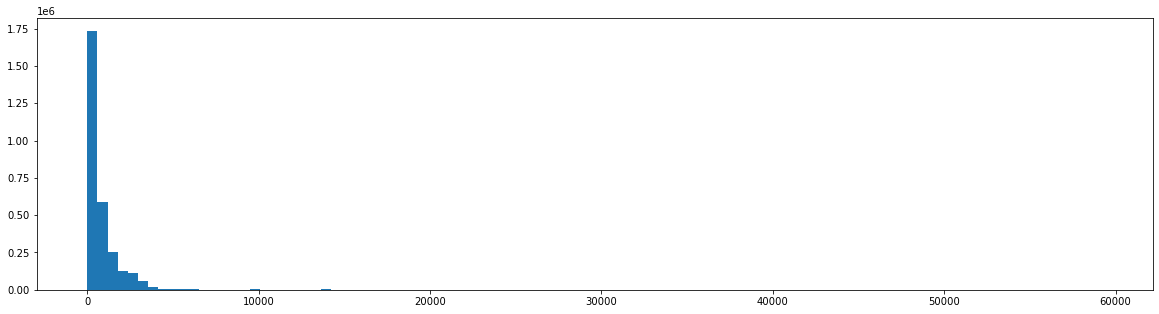

In [24]:
# ~20,000 entries are below item_price 60,000 and above 10,000. So even though most items are much cheaper, there's a fair amount of data here
print(len(df.loc[(df['item_price'] < 6e4) & (df['item_price'] > 1e4), 'item_price']))
df.loc[df['item_price'] < 6e4, 'item_price'].hist(grid=False, bins=100, figsize=(20, 5))


<AxesSubplot:>

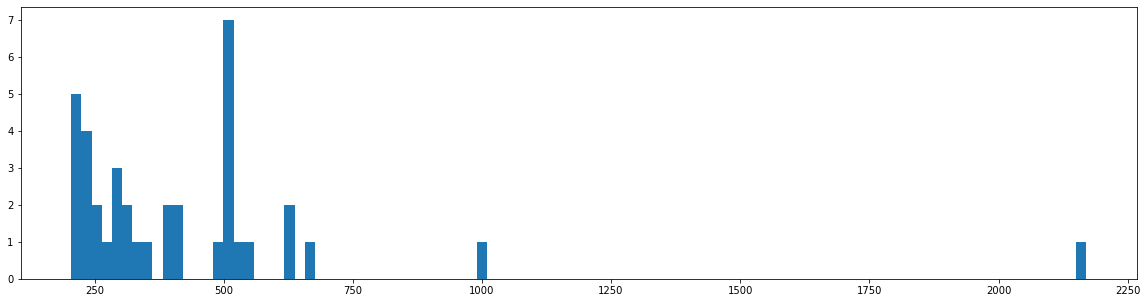

In [46]:
# we have some outliers in 'item_cnt_day'
df.loc[df['item_cnt_day'] > 200, 'item_cnt_day'].hist(grid=False, bins=100, figsize=(20, 5))

In [49]:
df.loc[df['item_cnt_day'] > 750]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2015-01-15,24,12,20949,4.000000,1000.0,71
2015-10-28,33,12,11373,0.908714,2169.0,9


In [51]:
df[(df['item_id'] == 20949) & (df['shop_id'] == 12)]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2014-12-19,23,12,20949,4.0,500.0,71
2015-01-15,24,12,20949,4.0,1000.0,71
2015-10-14,33,12,20949,4.0,500.0,71


In [52]:
df[(df['item_id'] == 11373) & (df['shop_id'] == 12)]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-01-02,1,12,11373,229.0,1.0,9
2013-01-08,7,12,11373,133.8,5.0,9
2013-01-09,8,12,11373,245.0,2.0,9
2013-01-31,0,12,11373,97.8,5.0,9
2013-02-04,3,12,11373,163.0,1.0,9
...,...,...,...,...,...,...
2015-12-02,25,12,11373,263.4,10.0,9
2015-12-03,26,12,11373,643.0,12.0,9
2015-12-05,28,12,11373,510.0,1.0,9


In [55]:
# what items are these outliers?
# item 11373 seems like a delivery company (Boxberry)
# item 20949 is either a tshirt or a packaging material or perhaps a white plastic bag according to google translate
# we probably don't know enough throw these away as outliers
items[(items['item_id'] == 11373) | (items['item_id'] == 20949)]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [25]:
# how many unique item id's (or should I use item_category_id for more data?) at a particular shop
df.loc[df['shop_id'] == 6, 'item_id'].value_counts()

20949    771
2808     339
17717    330
4181     328
5822     316
        ... 
18759      1
294        1
20804      1
18735      1
6563       1
Name: item_id, Length: 11856, dtype: int64

<AxesSubplot:xlabel='date'>

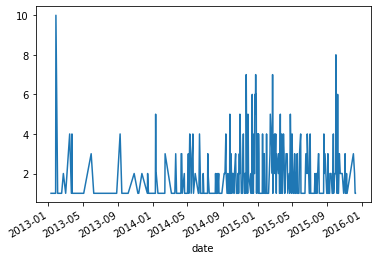

In [26]:
df.loc[(df['item_id'] == 17717) & (df['shop_id'] == 6), 'item_cnt_day'].plot()

In [27]:
test = pd.read_csv('test.csv')

# the shops not listed here all seem to have weird behavior towards the end of their time series
# perhaps we should only use the shop id's listed in the following array
test_shops = test['shop_id'].unique()
test_shops.sort()
print(test_shops)

[ 2  3  4  5  6  7 10 12 14 15 16 18 19 21 22 24 25 26 28 31 34 35 36 37
 38 39 41 42 44 45 46 47 48 49 50 52 53 55 56 57 58 59]


<AxesSubplot:xlabel='date'>

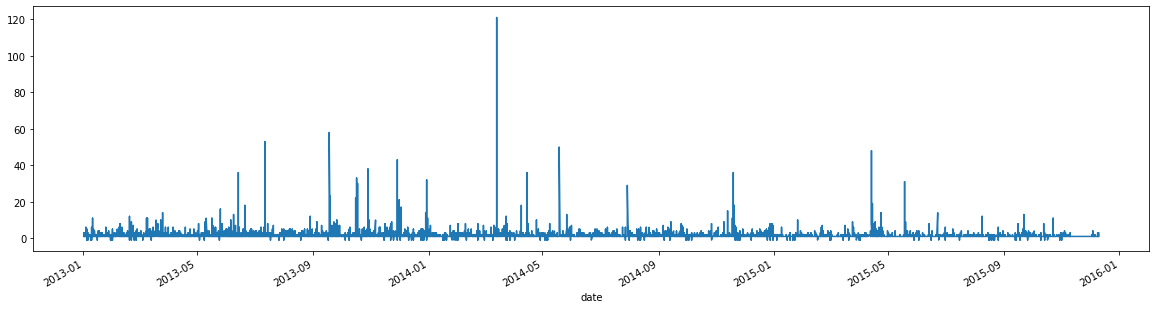

In [28]:
# example shops with weird behaviour, especially in the last few months/year
df.loc[df['shop_id'] == 52, 'item_cnt_day'].plot(figsize=(20, 5))

<AxesSubplot:xlabel='date'>

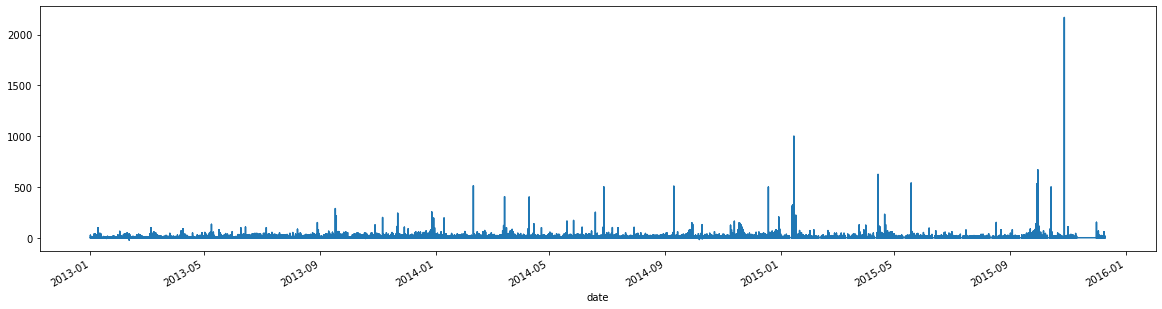

In [334]:

df.loc[df['shop_id'].isin(test_shops), 'item_cnt_day'].plot(figsize=(20, 5))


<AxesSubplot:xlabel='date', ylabel='item_cnt_day'>

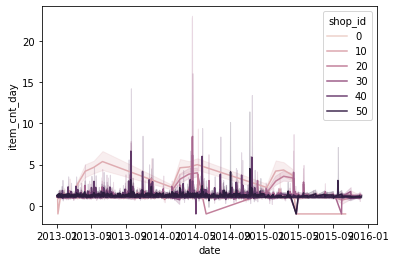

In [29]:
# plotting all the shops that supposedly have weird behaviour
lol = df.copy()
lol['date'] = lol.index

lol = lol.loc[~lol['shop_id'].isin(test_shops), ['shop_id', 'item_cnt_day', 'date']]

# seaborn works but is too slow - not clear plotting a separate line for each "bad shop" shows what we want anyway
sns.lineplot(data=lol, x='date', y='item_cnt_day', hue='shop_id')